In [1]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from arch import arch_model
from arch.univariate import StudentsT
from statsmodels.stats.diagnostic import acorr_ljungbox

# Phân tích mô tả giá cổ phiếu FPT

## 1. Load dữ liệu

## 1.1. Tải dữ liệu lên từ tệp

In [3]:
# --- Đọc file từ file dữ liệu ---
fpt_historical_stock_price = pd.read_csv(
    r'..\..\data\raw\fpt\fpt_historical_price.csv', 
    parse_dates=['time'], 
    index_col='time'
)
# --- Tạo data range ---
full_date_range = pd.date_range(
    start='2020-01-01', 
    end=fpt_historical_stock_price.index.max(), 
    freq='D'
)
# --- Ép bảng dữ liệu theo thời gian ---
fpt_historical_stock_price = fpt_historical_stock_price.reindex(full_date_range)
print(fpt_historical_stock_price.head(10))

             open   high    low  close     volume
2020-01-01    NaN    NaN    NaN    NaN        NaN
2020-01-02  21.28  21.54  21.17  21.39   896720.0
2020-01-03  21.50  21.57  20.95  21.03  2047880.0
2020-01-04    NaN    NaN    NaN    NaN        NaN
2020-01-05    NaN    NaN    NaN    NaN        NaN
2020-01-06  20.84  21.03  20.73  20.81  1091660.0
2020-01-07  20.92  21.21  20.81  21.21   837240.0
2020-01-08  20.99  21.06  20.73  20.73  1814290.0
2020-01-09  20.92  21.06  20.84  21.03   967050.0
2020-01-10  20.99  21.10  20.84  20.99  1018650.0


## 1.2. Thao tác thay đổi bảng dữ liệu

In [4]:
# --- Chuẩn bị các cột cần lọc ---
_columns_should_be_dropped = ['open', 'high', 'low'] 
_columns_to_drop = fpt_historical_stock_price.columns.intersection(
    _columns_should_be_dropped
)

# --- Tiến hành lọc các cột không cần thiết ---
fpt_historical_stock_price.drop(
    columns = _columns_to_drop, 
    inplace=True
)
fpt_historical_stock_price = fpt_historical_stock_price[fpt_historical_stock_price.index <= '2025-09-30']
print(fpt_historical_stock_price.head())

            close     volume
2020-01-01    NaN        NaN
2020-01-02  21.39   896720.0
2020-01-03  21.03  2047880.0
2020-01-04    NaN        NaN
2020-01-05    NaN        NaN


# 2. EDA

## 2.1. Thông tin cơ bản về dữ liệu

In [5]:
print('\n> Phần 01: Phương thức .info()')
print('-' * 50)
print(fpt_historical_stock_price.info())

print('\n> Phần 02: Phương thức .describe()')
print('-' * 50)
print(fpt_historical_stock_price.describe())


> Phần 01: Phương thức .info()
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2020-01-01 to 2025-09-30
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1433 non-null   float64
 1   volume  1433 non-null   float64
dtypes: float64(2)
memory usage: 49.2 KB
None

> Phần 02: Phương thức .describe()
--------------------------------------------------
             close        volume
count  1433.000000  1.433000e+03
mean     61.738821  2.976654e+06
std      32.333544  2.877128e+06
min      14.750000  2.219660e+05
25%      42.530000  1.291360e+06
50%      51.270000  2.098979e+06
75%      86.590000  3.472300e+06
max     133.040000  2.351430e+07


In [6]:
print(f'Số ngày được khảo sát            : {len(fpt_historical_stock_price)} ngày')

print(f'Khảo sát missing value:')
print(f' - Giá đóng cửa (close)          : {fpt_historical_stock_price["close"].isnull().sum()} mẫu')
print(f' - Khối lượng giao dịch (volume) : {fpt_historical_stock_price["volume"].isnull().sum()} mẫu')
condition = (fpt_historical_stock_price['close'].isnull()) & (fpt_historical_stock_price['volume'].isnull())
_days_not_on_transaction = len(fpt_historical_stock_price[condition])

print(f'Số ngày không có giao dịch (NaN) : {_days_not_on_transaction} ngày')
_rate_of_days_not_on_transaction = _days_not_on_transaction / len(fpt_historical_stock_price) * 100
print(f'Tỉ lệ ngày không có giao dịch (%): {_rate_of_days_not_on_transaction:.2f}%')

Số ngày được khảo sát            : 2100 ngày
Khảo sát missing value:
 - Giá đóng cửa (close)          : 667 mẫu
 - Khối lượng giao dịch (volume) : 667 mẫu
Số ngày không có giao dịch (NaN) : 667 ngày
Tỉ lệ ngày không có giao dịch (%): 31.76%


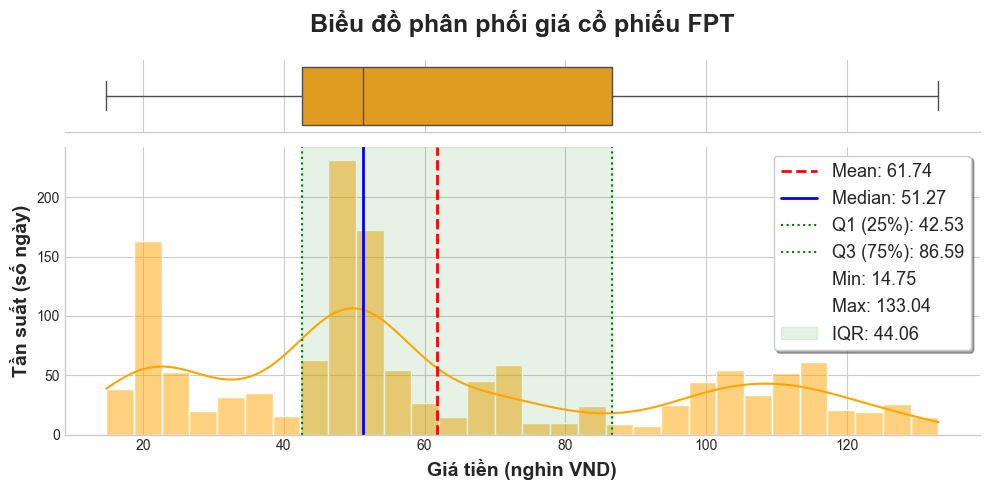

In [48]:
# --- Tính toán đầy đủ các chỉ số thống kê ---
data = fpt_historical_stock_price['close']
mean_val = data.mean()
median_val = data.median()
min_val = data.min()
max_val = data.max()
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1

# =======================
# VẼ BIỂU ĐỒ
# =======================
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=(10, 5))
sns.set_style("whitegrid")

# --- Boxplot ---
sns.boxplot(x=data, ax=ax_box, color='orange', fliersize=5)
ax_box.set(xlabel='') 
ax_box.set_title('Biểu đồ phân phối giá cổ phiếu FPT', fontsize=18, fontweight='bold', pad=20)

# --- Histogram ---
sns.histplot(data, bins=30, kde=True, color='orange', ax=ax_hist)

# --- Vẽ Mean & Median ---
ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
ax_hist.axvline(median_val, color='blue', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

# --- Thêm các đường giới hạn Q1, Q3 ---
ax_hist.axvline(q1, color='green', linestyle=':', linewidth=1.5, label=f'Q1 (25%): {q1:.2f}')
ax_hist.axvline(q3, color='green', linestyle=':', linewidth=1.5, label=f'Q3 (75%): {q3:.2f}')

# --- Thêm Min, Max vào Legend ---
ax_hist.plot([], [], ' ', label=f'Min: {min_val:.2f}')
ax_hist.plot([], [], ' ', label=f'Max: {max_val:.2f}')

# --- Vẽ vùng IQR ---
ax_hist.axvspan(q1, q3, color='green', alpha=0.1, label=f'IQR: {iqr:.2f}')


ax_hist.set_xlabel('Giá tiền (nghìn VND)', fontsize=14, fontweight='bold')
ax_hist.set_ylabel('Tần suất (số ngày)', fontsize=14, fontweight='bold')
ax_hist.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=13, frameon=True, shadow=True)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.tight_layout()
plt.show()

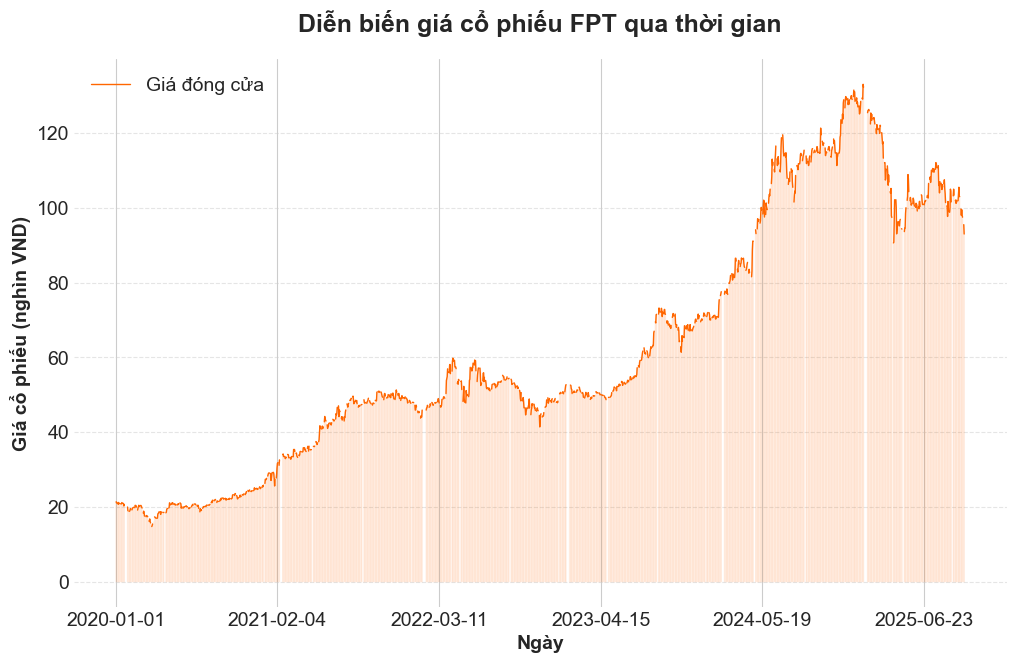

In [43]:
plt.figure(figsize=(10, 6))

plt.plot(
    fpt_historical_stock_price.index,
    fpt_historical_stock_price['close'],
    color='#FF6600', linewidth=1, label='Giá đóng cửa'
)

plt.fill_between(
    fpt_historical_stock_price.index,
    fpt_historical_stock_price['close'],
    color='#FF6600', alpha=0.1
)

plt.xticks(
    fpt_historical_stock_price.index[::400],
    rotation=0,
    fontsize=14
)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.box(False)
plt.tight_layout()

plt.title('Diễn biến giá cổ phiếu FPT qua thời gian', fontsize=18, fontweight='bold', pad=20)
plt.legend(frameon=False, fontsize=14, loc='upper left')

plt.style.use('seaborn-v0_8-whitegrid')
plt.xlabel('Ngày', fontsize=14, fontweight='bold')
plt.ylabel('Giá cổ phiếu (nghìn VND)', fontsize=14, fontweight='bold')
plt.show()


## 2.2. Điền missing value

In [55]:
# 1. Xử lý Volume: Thay NaN bằng 0
fpt_historical_stock_price['volume'] = fpt_historical_stock_price['volume'].fillna(0)

# 2. Xử lý Close:
# Bước 1: ffill (lấy giá ngày trước đắp vào ngày nghỉ)
# Bước 2: bfill (đề phòng trường hợp ngày đầu tiên của dữ liệu bị NaN, lấy giá ngày sau đắp ngược lại)
fpt_historical_stock_price['close'] = fpt_historical_stock_price['close'].ffill().bfill()

# Kiểm tra lại kết quả sau khi điền
print('\n> Kiểm tra sau khi xử lý missing value:')
print('-' * 50)
print(fpt_historical_stock_price[['close', 'volume']].info())
print(fpt_historical_stock_price[['close', 'volume']].head())


> Kiểm tra sau khi xử lý missing value:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2020-01-01 to 2025-09-30
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2100 non-null   float64
 1   volume  2100 non-null   float64
dtypes: float64(2)
memory usage: 49.2 KB
None
            close     volume
2020-01-01  21.39        0.0
2020-01-02  21.39   896720.0
2020-01-03  21.03  2047880.0
2020-01-04  21.03        0.0
2020-01-05  21.03        0.0


Text(0, 0.5, 'Giá (ngàn VNĐ)')

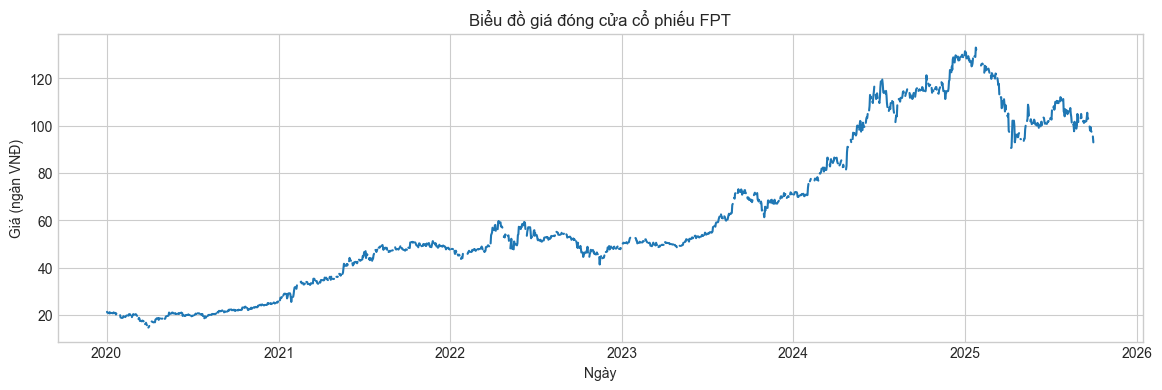

In [49]:
plt.figure(figsize=(14, 4))
plt.plot(
    fpt_historical_stock_price['close']
)

plt.title('Biểu đồ giá đóng cửa cổ phiếu FPT')
plt.xlabel('Ngày')
plt.ylabel('Giá (ngàn VNĐ)')

# 3. Phân tích xu hướng

## 3.1. Phân rã dữ liệu

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def plot_seasonal_decompose(df, column='close', model='additive', period=30):
    """
    Hàm thực hiện phân rã chuỗi thời gian thành 4 thành phần:
    1. Observed (Gốc)
    2. Trend (Xu hướng)
    3. Seasonal (Mùa vụ)
    4. Residual (Nhiễu/Phần dư)
    
    Tham số:
    - df: DataFrame chứa dữ liệu (Index phải là Datetime)
    - column: Tên cột cần phân tích (mặc định 'close')
    - model: 'additive' (Cộng) hoặc 'multiplicative' (Nhân)
    - period: Chu kỳ lặp lại (ví dụ: 30 cho tháng, 7 cho tuần, 365 cho năm)
    """
    
    result = seasonal_decompose(df[column], model=model, period=period)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    # --- Observed ---
    axes[0].plot(result.observed, label='Observed (Gốc)', color='black', alpha=0.7)
    axes[0].set_ylabel('Giá trị')
    axes[0].set_title(f'Phân rã chuỗi thời gian: {column} (Model: {model}, Period: {period})', fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Giá tiền (nghìn VNĐ)')
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # --- Trend ---
    axes[1].plot(result.trend, label='Trend (Xu hướng)', color='red')
    axes[1].set_ylabel('Xu hướng')
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('Giá tiền (nghìn VNĐ)')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # --- Seasonal ---
    axes[2].plot(result.seasonal, label='Seasonality (Mùa vụ)', color='green')
    axes[2].set_ylabel('Mùa vụ')
    axes[2].legend(loc='upper left')
    axes[2].grid(True, linestyle='--', alpha=0.5)

    # --- Residual ---
    axes[3].scatter(result.resid.index, result.resid, label='Residuals (Nhiễu)', color='grey', s=10, alpha=0.6)
    axes[3].axhline(0, color='black', linestyle='--', linewidth=1) # Đường 0 tham chiếu
    axes[3].set_ylabel('Phần dư')
    axes[3].legend(loc='upper left')
    axes[3].grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Thời gian')
    plt.tight_layout()
    plt.show()

    return result

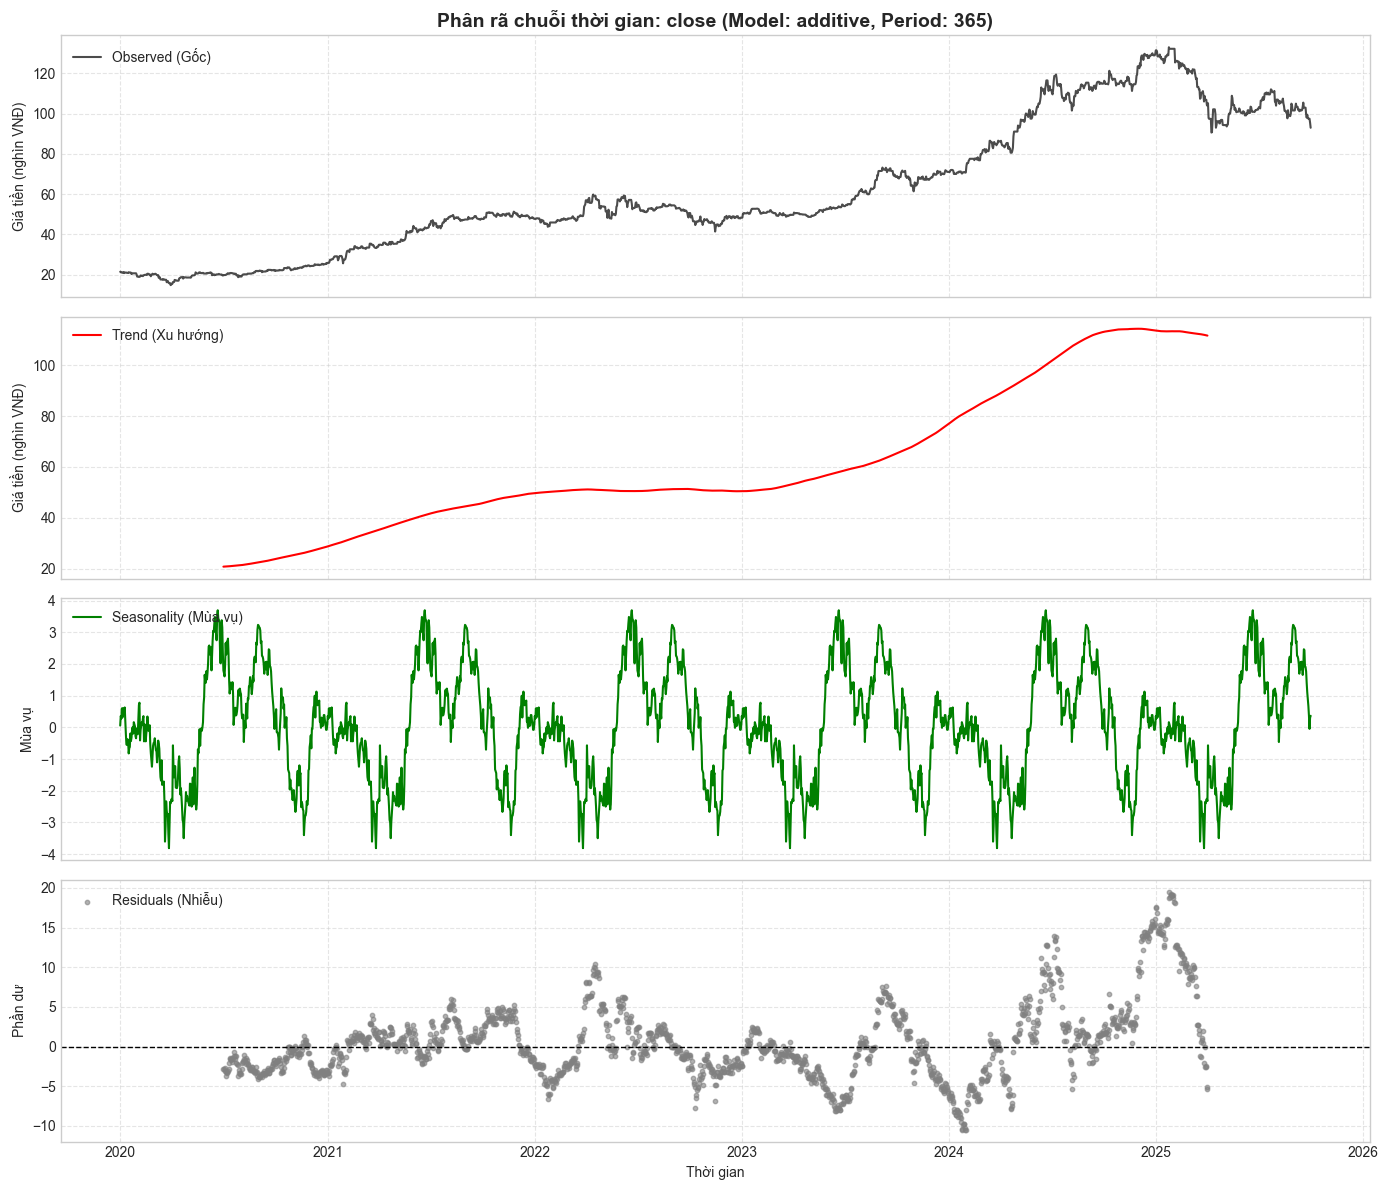

In [57]:
decomposition_result = plot_seasonal_decompose(
    fpt_historical_stock_price,
    'close',
    'additive',
    365
)

## 3.2. Kiểm định tính dừng của phần dư

In [58]:
def check_stationarity_adf(timeseries, column_name="Dữ liệu"):
    """
    Thực hiện kiểm định ADF và in kết quả.
    """
    timeseries = timeseries.dropna()
    
    result = adfuller(timeseries, autolag='AIC')
    
    print(f"\n--- Kết quả kiểm định ADF cho chuỗi {column_name} ---")
    print(f'H0: Chuỗi {column_name} là chuỗi không dừng')
    print(f'H1: Chuỗi {column_name} là chuỗi dừng')
    print(f"Giá trị thống kê ADF (ADF Statistic): {result[0]:.4f}")
    print(f"Giá trị p (p-value): {result[1]:.4f}")
    print(f"Số lượng độ trễ (Lags used): {result[2]}")
    print("Các giá trị giới hạn quan trọng (Critical Values):")
    for key, value in result[4].items():
        print(f"   {key}: {value:.6f}")

    if result[1] <= 0.05:
        print(f"\nKết luận: Chuỗi {column_name} là dừng.")
    else:
        print(f"\nKết luận: Chuỗi {column_name} là không dừng.")

In [59]:

residual_series = decomposition_result.resid
check_stationarity_adf(residual_series, column_name="Phần dư (Residual)")


--- Kết quả kiểm định ADF cho chuỗi Phần dư (Residual) ---
H0: Chuỗi Phần dư (Residual) là chuỗi không dừng
H1: Chuỗi Phần dư (Residual) là chuỗi dừng
Giá trị thống kê ADF (ADF Statistic): -3.4735
Giá trị p (p-value): 0.0087
Số lượng độ trễ (Lags used): 0
Các giá trị giới hạn quan trọng (Critical Values):
   1%: -3.434125
   5%: -2.863207
   10%: -2.567658

Kết luận: Chuỗi Phần dư (Residual) là dừng.


## 3.3. Phân tích xu hướng và phần dư

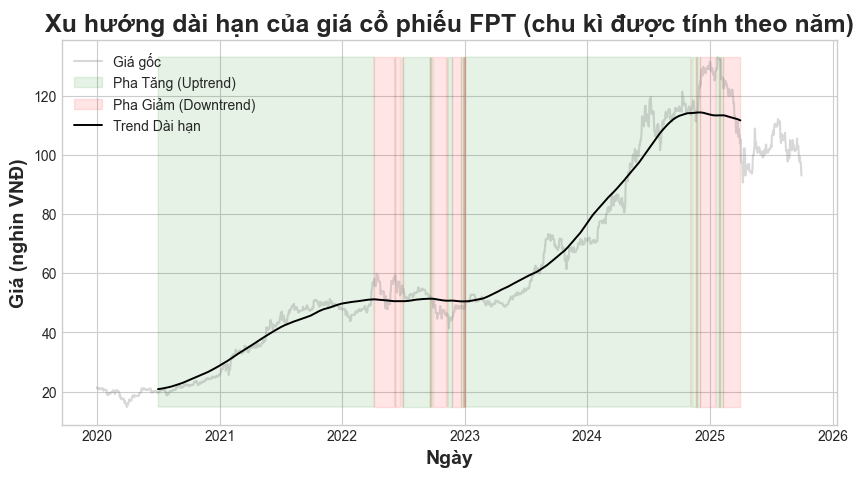

In [88]:
trend_data = decomposition_result.trend.dropna()
trend_slope = trend_data.diff()


plt.figure(figsize=(10, 5))
plt.plot(fpt_historical_stock_price.index, fpt_historical_stock_price['close'], color='gray', alpha=0.3, label='Giá gốc')
plt.fill_between(trend_data.index, fpt_historical_stock_price['close'].min(), fpt_historical_stock_price['close'].max(), 
                 where=(trend_slope > 0), color='green', alpha=0.1, label='Pha Tăng (Uptrend)')
plt.fill_between(trend_data.index, fpt_historical_stock_price['close'].min(), fpt_historical_stock_price['close'].max(), 
                 where=(trend_slope < 0), color='red', alpha=0.1, label='Pha Giảm (Downtrend)')

plt.plot(trend_data.index, trend_data, color='black', linewidth=1.4, label='Trend Dài hạn')

plt.title('Xu hướng dài hạn của giá cổ phiếu FPT (chu kì được tính theo năm)', fontsize=18, fontweight='bold')
plt.legend(loc='upper left')
plt.xlabel('Ngày',fontsize=14, fontweight='bold')
plt.ylabel('Giá (nghìn VNĐ)', fontsize=14, fontweight='bold')
plt.show()

In [61]:
resid = decomposition_result.resid.dropna()

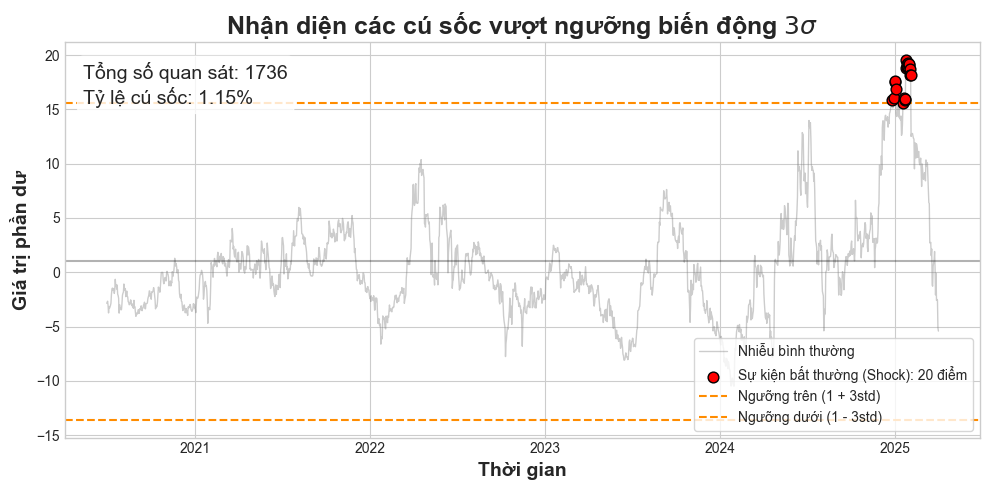

Tỷ lệ sự kiện bất thường: 1.1521%


In [91]:
# --- Tính toán thống kê ---
sigma = resid.std()
threshold_upper = 1 + 3 * sigma
threshold_lower = 1 - 3 * sigma

# --- Lọc outliers và tính tỷ lệ ---
outliers = resid[(resid > threshold_upper) | (resid < threshold_lower)]
total_obs = len(resid)
outlier_count = len(outliers)
outlier_ratio = (outlier_count / total_obs) * 100

# --- Trực quan hóa ---
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Vẽ thành phần nhiễu
plt.plot(resid.index, resid, color='gray', alpha=0.4, label='Nhiễu bình thường', linewidth=1)

# Đánh dấu các cú sốc (Outliers)
plt.scatter(outliers.index, outliers, color='red', s=60, edgecolors='black', zorder=5, 
            label=f'Sự kiện bất thường (Shock): {outlier_count} điểm')

# Vẽ ngưỡng 3-sigma
plt.axhline(threshold_upper, color='darkorange', linestyle='--', linewidth=1.5, label='Ngưỡng trên (1 + 3std)')
plt.axhline(threshold_lower, color='darkorange', linestyle='--', linewidth=1.5, label='Ngưỡng dưới (1 - 3std)')
plt.axhline(1, color='black', linestyle='-', alpha=0.3)

# Hiển thị tỷ lệ phần trăm trực tiếp trên biểu đồ
info_text = f"Tổng số quan sát: {total_obs}\nTỷ lệ cú sốc: {outlier_ratio:.2f}%"
plt.gca().text(0.02, 0.95, info_text, transform=plt.gca().transAxes, fontsize=14,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Nhận diện các cú sốc vượt ngưỡng biến động $3\sigma$', fontsize=18, fontweight='bold')
plt.xlabel('Thời gian', fontsize=14, fontweight='bold')
plt.ylabel('Giá trị phần dư', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

print(f"Tỷ lệ sự kiện bất thường: {outlier_ratio:.4f}%")

In [63]:
print("\n--- 1. Thống kê Mô tả của Phần dư (Residuals) ---")
variance = resid.var()

print(resid.describe())
print(f"Phương sai (Variance) của Phần dư: {variance:.6f}")

total_days = len(resid)
num_outliers = len(outliers)
percent_outliers = (num_outliers / total_days) * 100

print("\n--- 2. Thống kê Outliers (Cú sốc) ---")
print(f"Tổng số ngày giao dịch: {total_days}")
print(f"Số lượng ngày bất thường tìm thấy: {num_outliers}")
print(f"Tỷ lệ ngày bất thường: {percent_outliers:.2f}%")

if num_outliers > 0:
    avg_shock_magnitude = (outliers.abs() - 1).mean()
    print(f"Độ lớn sai lệch trung bình của các cú sốc: {avg_shock_magnitude:.4f}")


--- 1. Thống kê Mô tả của Phần dư (Residuals) ---
count    1736.000000
mean        0.590035
std         4.859183
min       -10.490540
25%        -2.505305
50%        -0.061491
75%         2.594445
max        19.521624
Name: resid, dtype: float64
Phương sai (Variance) của Phần dư: 23.611658

--- 2. Thống kê Outliers (Cú sốc) ---
Tổng số ngày giao dịch: 1736
Số lượng ngày bất thường tìm thấy: 20
Tỷ lệ ngày bất thường: 1.15%
Độ lớn sai lệch trung bình của các cú sốc: 16.7552


# 4. Mô hình hóa biến động lợi suất logarithm với ARIMA-GARCH

## 4.1. Sinh chuỗi lợi suất logarit (Logarit Return)

In [64]:
log_returns = (fpt_historical_stock_price['close'].pct_change()).apply(lambda x: np.log(1+x)).dropna()
train_log_returns, test_log_returns = log_returns[:-250], log_returns[-250:]

In [65]:
train_log_returns

2020-01-02    0.000000
2020-01-03   -0.016974
2020-01-04    0.000000
2020-01-05    0.000000
2020-01-06   -0.010516
                ...   
2025-01-19    0.000000
2025-01-20    0.006672
2025-01-21   -0.000619
2025-01-22   -0.001394
2025-01-23    0.030295
Freq: D, Name: close, Length: 1849, dtype: float64

In [66]:
test_log_returns

2025-01-24   -0.005880
2025-01-25    0.000000
2025-01-26    0.000000
2025-01-27    0.000000
2025-01-28    0.000000
                ...   
2025-09-26   -0.005115
2025-09-27    0.000000
2025-09-28    0.000000
2025-09-29   -0.020726
2025-09-30   -0.026527
Freq: D, Name: close, Length: 250, dtype: float64

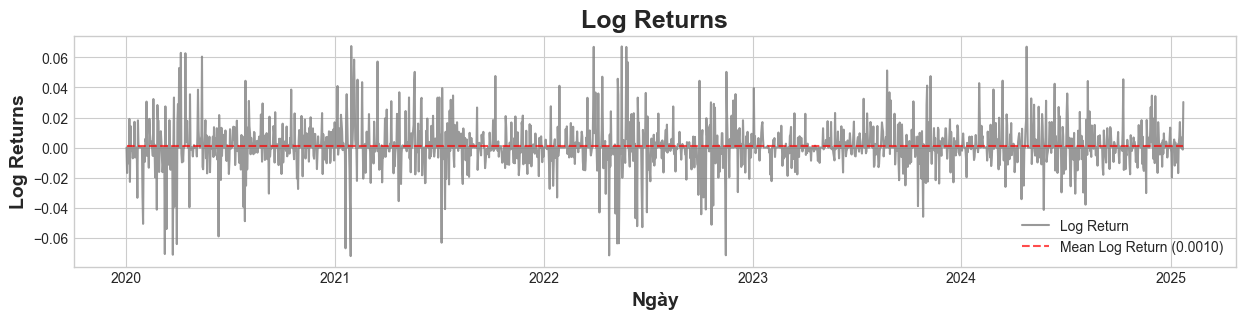

In [95]:
plt.figure(figsize=(15, 3))

_mean_log_return = train_log_returns.mean()
start_index = train_log_returns.index.min()
end_index = train_log_returns.index.max()

plt.plot(
    train_log_returns, 
    alpha = 0.8,
    label = 'Log Return',
    color = 'gray'
)
plt.plot([start_index, end_index], 
         [_mean_log_return, _mean_log_return], 
         '--', 
         color='red',
         alpha=0.7, 
         label=f'Mean Log Return ({_mean_log_return:.4f})')

plt.xlabel('Ngày', fontsize=14, fontweight='bold')
plt.ylabel('Log Returns', fontsize=14, fontweight='bold')
plt.title('Log Returns', fontsize=18, fontweight='bold')
plt.legend()



## 4.2. Kiểm định tính dừng

In [68]:
def adf_test(timeseries):
    print("==================================================")
    print("KẾT QUẢ KIỂM ĐỊNH AUGMENTED DICKEY-FULLER (ADF)")
    print("==================================================")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print(dfoutput)
    print("--------------------------------------------------")
    
    print("KẾT LUẬN:")
    if dfoutput['p-value'] < 0.05:
        print("p-value < 0.05 => Bác bỏ H0.")
        print("+ Chuỗi dữ liệu có TÍNH DỪNG (Stationary).")
        print("+ Đủ điều kiện để chạy mô hình ARIMA/GARCH.")
    else:
        print("p-value >= 0.05 => Chấp nhận H0.")
        print("+ Chuỗi dữ liệu KHÔNG DỪNG (Non-Stationary).")
        print("+ Cần lấy sai phân (Differencing) trước khi mô hình hóa.")
    print("==================================================")

In [69]:
adf_test(train_log_returns)

KẾT QUẢ KIỂM ĐỊNH AUGMENTED DICKEY-FULLER (ADF)
Test Statistic                  -24.614224
p-value                           0.000000
# Lags Used                       2.000000
Number of Observations Used    1846.000000
Critical Value (1%)              -3.433897
Critical Value (5%)              -2.863107
Critical Value (10%)             -2.567604
dtype: float64
--------------------------------------------------
KẾT LUẬN:
p-value < 0.05 => Bác bỏ H0.
+ Chuỗi dữ liệu có TÍNH DỪNG (Stationary).
+ Đủ điều kiện để chạy mô hình ARIMA/GARCH.


## 4.3. Kiểm định tự tương quan Ljung-Box test

In [70]:
def ljung_box_multi_lags(series, lags_list=[5, 10, 15, 20]):
    """
    Thực hiện kiểm định Ljung-Box tại nhiều độ trễ khác nhau.
    
    Args:
    series (pd.Series): Chuỗi dữ liệu (Log Returns hoặc Residuals)
    lags_list (list): Danh sách các lag muốn kiểm tra
    """
    print("==========================================================")
    print(f"KẾT QUẢ KIỂM ĐỊNH LJUNG-BOX (VỚI LAG = {lags_list})")
    print("==========================================================")
    
    lb_result = acorr_ljungbox(series.dropna(), lags=lags_list, return_df=True)
    
    lb_result.columns = ['Test Statistic', 'p-value']
    
    lb_result['Kết luận (H0)'] = lb_result['p-value'].apply(
        lambda x: 'Có tương quan' if x < 0.05 else 'Ngẫu nhiên'
    )
    
    print(lb_result)
    print("----------------------------------------------------------")
    
    all_random = (lb_result['p-value'] >= 0.05).all()
    if all_random:
        print("TỔNG KẾT: Chuỗi dữ liệu là NGẪU NHIÊN (White Noise) ở mọi độ trễ kiểm tra.")
    else:
        print("TỔNG KẾT: Tồn tại sự tự tương quan ở một số độ trễ nhất định.")
    print("==========================================================")

In [71]:
# Hàm ljung_box_multi_lags() đã được tự định nghĩa trước đó
temp = [1, 2, 3, 4, 5, 10]
print('Kiểm định Ljung-Box cho chuỗi lợi suất')
ljung_box_multi_lags(train_log_returns, lags_list=temp)

Kiểm định Ljung-Box cho chuỗi lợi suất
KẾT QUẢ KIỂM ĐỊNH LJUNG-BOX (VỚI LAG = [1, 2, 3, 4, 5, 10])
    Test Statistic   p-value Kết luận (H0)
1         1.107832  0.292554    Ngẫu nhiên
2         3.516296  0.172364    Ngẫu nhiên
3         6.449124  0.091691    Ngẫu nhiên
4         6.463932  0.167077    Ngẫu nhiên
5         8.222437  0.144395    Ngẫu nhiên
10       11.775777  0.300343    Ngẫu nhiên
----------------------------------------------------------
TỔNG KẾT: Chuỗi dữ liệu là NGẪU NHIÊN (White Noise) ở mọi độ trễ kiểm tra.


In [72]:
# Hàm ljung_box_multi_lags() đã được tự định nghĩa trước đó
temp = [1, 2, 3, 4, 5, 10]
print('Kiểm định Ljung-Box cho bình phương chuỗi lợi suất')
ljung_box_multi_lags(train_log_returns ** 2, lags_list=temp)

Kiểm định Ljung-Box cho bình phương chuỗi lợi suất
KẾT QUẢ KIỂM ĐỊNH LJUNG-BOX (VỚI LAG = [1, 2, 3, 4, 5, 10])
    Test Statistic       p-value  Kết luận (H0)
1        40.578392  1.888839e-10  Có tương quan
2        44.052734  2.716880e-10  Có tương quan
3        54.866344  7.332086e-12  Có tương quan
4        57.008476  1.232115e-11  Có tương quan
5        60.008216  1.210714e-11  Có tương quan
10      150.960883  2.364309e-27  Có tương quan
----------------------------------------------------------
TỔNG KẾT: Tồn tại sự tự tương quan ở một số độ trễ nhất định.


## 4.2. Mô hình hóa biến động lợi suất logarit

In [ ]:
def arima_garch(log_returns: pd.Series, arima_order=(0, 0, 0)):    
    
    # --- Áp dụng ARIMA trích xuất phần dư ---
    print('> ARIMA(0, 0, 0)')
    log_returns = log_returns.astype(float) * 100
    
    model_arima = ARIMA(log_returns, order=arima_order)
    arima_fit = model_arima.fit()
    print(arima_fit.summary())
    residuals = arima_fit.resid
    print(residuals)

    # --- Áp dụng mô hình GARCH(1, 1) ---
    print('\n> Standard GARCH(1, 1)')
    
    am = arch_model(residuals, 
        vol='Garch',
        p=1, 
        q=1,
        mean='Constant',
        dist='StudentsT',
        rescale=False
    )
    
    res = am.fit(disp='off')
    print(res.summary())

    # --- TRÍCH XUẤT VÀ TRỰC QUAN HÓA ---
    print("\n==================================================")
    print("> TRÍCH XUẤT ĐỘ BIẾN ĐỘNG CÓ ĐIỀU KIỆN (SIGMA_T)")
    print("==================================================")
    conditional_std = res.conditional_volatility
    conditional_std_pct = conditional_std 
    print(f"Độ biến động trung bình hàng ngày (STD): {conditional_std_pct.mean():.4f}%")
    print(f"Độ biến động tối đa hàng ngày (STD): {conditional_std_pct.max():.4f}%")
    
    plt.figure(figsize=(15, 5))
    plt.plot(conditional_std_pct, 
             label=f'Conditional Volatility ($\sigma_t$)', 
             color='red', 
             linewidth=1.0)
    
    plt.title(f'Độ Biến động Có Điều kiện: ARIMA{arima_order}-Standard GARCH(1,1)')
    plt.xlabel('Ngày')
    plt.ylabel('Độ biến động (Phần trăm %)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return {
        'model_summary': res.summary(),
        'conditional_volatility': conditional_std,
        'arima_model': arima_fit,
        'garch_model': res 
    }

> ARIMA(0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1849
Model:                          ARIMA   Log Likelihood               -3302.227
Date:                Fri, 02 Jan 2026   AIC                           6608.454
Time:                        16:39:00   BIC                           6619.499
Sample:                    01-02-2020   HQIC                          6612.525
                         - 01-23-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0988      0.034      2.944      0.003       0.033       0.165
sigma2         2.0835      0.034     60.895      0.000       2.016       2.151
Ljung-Box (L1) (Q):                

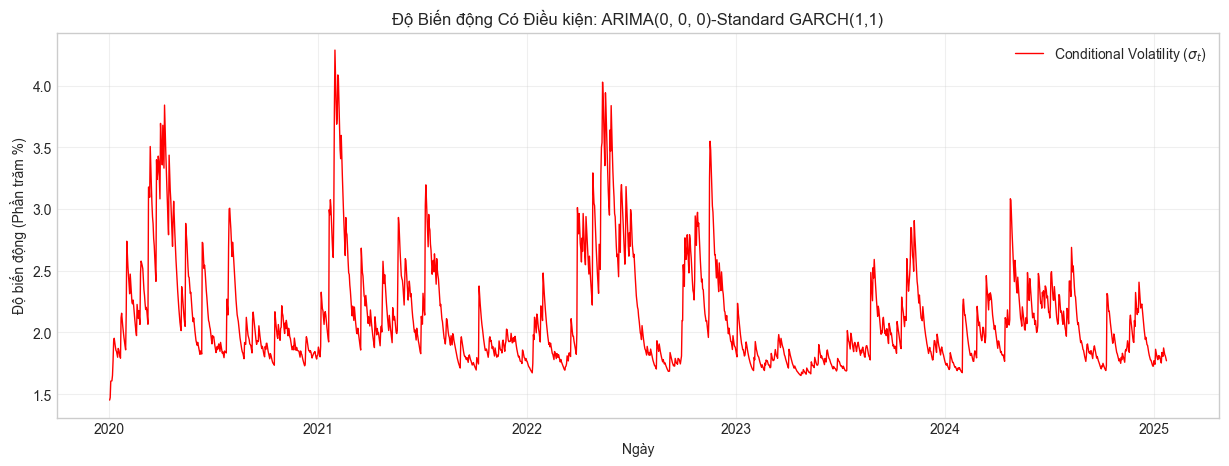

In [74]:
analyzed_result = arima_garch(log_returns=train_log_returns)

## 4.3. Dự đoán

In [75]:
def get_forecast_std(
    trained_model_res,
    train_data: pd.Series,
    test_data: pd.Series
) -> pd.Series:
    if train_data.abs().mean() < 0.5:
        train_data = train_data * 100
        test_data = test_data * 100

    full_data = pd.concat([train_data, test_data])
    
    am_full = arch_model(full_data, 
                         vol='Garch', p=1, q=1, 
                         mean='Constant', 
                         dist='StudentsT', 
                         rescale=False)
    

    params = trained_model_res.params
    fixed_res = am_full.fix(params)
    
    full_volatility = fixed_res.conditional_volatility
    test_volatility_std = full_volatility.loc[test_data.index]
    
    return test_volatility_std

In [76]:
forecasted_std_test = get_forecast_std(
    analyzed_result['garch_model'],
    train_log_returns, 
    test_log_returns
)

In [77]:
from scipy.stats import t as student_t

def monte_carlo_volatility_simulation(
    forecasted_std: pd.Series, 
    num_simulations: int = 5000, 
    nu_df: float = 6.0,
    alpha: float = 0.90
):

    n_days = len(forecasted_std)
    simulated_returns = np.zeros((n_days, num_simulations))
    shocks = student_t.rvs(df=nu_df, size=(n_days, num_simulations))
    sigma_array = forecasted_std.values[:, np.newaxis] 
    
    simulated_returns = sigma_array * shocks
    simulated_df = pd.DataFrame(simulated_returns, index=forecasted_std.index)
    lower_p = (1 - alpha) / 2 
    upper_p = 1 - lower_p
    
    percentiles = simulated_df.T.quantile([lower_p, upper_p]).T
    percentiles.columns = [f'{lower_p*100:.0f}th Percentile', f'{upper_p*100:.0f}th Percentile']

    return percentiles

percentiles_df = monte_carlo_volatility_simulation(
    forecasted_std=forecasted_std_test, 
    num_simulations=3000, 
    nu_df=analyzed_result['garch_model'].params['nu'],
    alpha=0.90
)

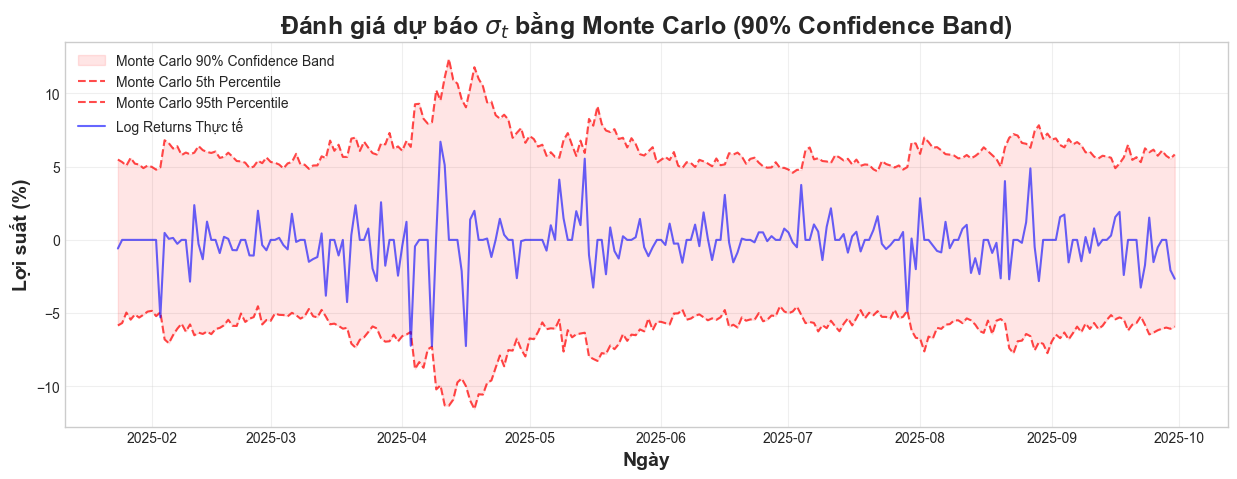

In [97]:
plt.figure(figsize=(15, 5))
plt.fill_between(
    percentiles_df.index, 
    percentiles_df['5th Percentile'], 
    percentiles_df['95th Percentile'], 
    color='red', 
    alpha=0.1,
    label='Monte Carlo 90% Confidence Band'
)
plt.plot(percentiles_df['5th Percentile'], 
         color='red', linestyle='--', alpha=0.7, 
         label='Monte Carlo 5th Percentile')
plt.plot(percentiles_df['95th Percentile'], 
         color='red', linestyle='--', alpha=0.7, 
         label='Monte Carlo 95th Percentile')

plt.plot(test_log_returns * 100, label='Log Returns Thực tế', color='blue', alpha=0.6)
plt.title(f'Đánh giá dự báo $\sigma_t$ bằng Monte Carlo (90% Confidence Band)', fontsize=18, fontweight='bold')
plt.xlabel('Ngày', fontsize=14, fontweight='bold')
plt.ylabel('Lợi suất (%)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()